## Import Library

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import difflib
# machine learning lib
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Get Data

---

In [2]:
# get csv files of player stats ,salary and inflation rate
salary_df = pd.read_csv('nba_salary_ESPN_cleaned.csv')
player_df = pd.read_csv('nba_player_stats_official.csv')
inflation_df = pd.read_csv('inflation_rates.csv')

In [3]:
# convert year by taking first 4 char of year feature
# i.e. 2019-20 will be 2019 now
player_df['year'] = player_df['year'].apply(lambda x: x[:4]).astype(int)

# convert year by subtracting year by 2
# i.e. 2020 will be 2018 now
salary_df['year'] = salary_df['year'].apply(lambda x: x - 2).astype(int)

In [4]:
# get close match for each name in salary dataframe with player dataframe
player_name = player_df['PLAYER_NAME'].unique()
salary_df['name_close_match'] = salary_df['NAME'].apply(
    lambda x: (difflib.get_close_matches(x, player_name)[:1] or [None])[0])

In [5]:
# inner join salary and player stats by player name and year
df = player_df.merge(salary_df, how = 'inner', 
                     left_on=['PLAYER_NAME','year'], right_on = ['name_close_match','year'])

In [6]:
# inner join inflation factor
inflation_df['Year'] = inflation_df['Year'] - 1
df = df.merge(inflation_df, how = 'inner', 
              left_on = ['year'], right_on = ['Year'])

In [7]:
# adjust raw salary based on inflation rate
df['SALARY_ADJ'] = df['SALARY'] * df['inf_factor']

In [8]:
# get data shape
df.shape

(7796, 76)

## Data Cleaning

---

In [9]:
# remove outliers
Q1 = df.SALARY_ADJ.quantile(0.25)
Q3 = df.SALARY_ADJ.quantile(0.75)
IQR = Q3 - Q1
df = df.loc[df['SALARY_ADJ'] <= Q3 + 1.5 * IQR]
df = df.loc[df['SALARY_ADJ'] >= Q1 - 1.5 * IQR]
df.reset_index(inplace = True, drop = True)

# change year feature's name to upper case
df['YEAR'] = df['year']
df.drop(['year'], 1, inplace = True)

In [10]:
# get stats of adjusted salary
df.SALARY_ADJ.describe().apply(lambda x: format(x, 'f'))

count        7331.000000
mean      5084220.609078
std       4672324.100461
min          5639.488065
25%       1416852.000000
50%       3435779.711918
75%       7457138.713570
max      19089412.059557
Name: SALARY_ADJ, dtype: object

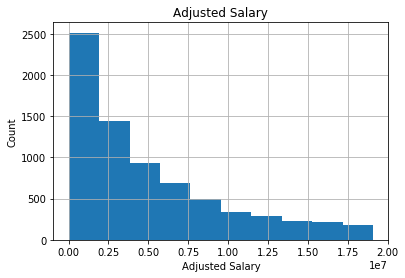

In [11]:
# plot the adjusted salary distribution
axarr = df.hist('SALARY_ADJ')
for ax in axarr.flatten():
    ax.set_xlabel('Adjusted Salary')
    ax.set_ylabel('Count')
    ax.set_title('Adjusted Salary')

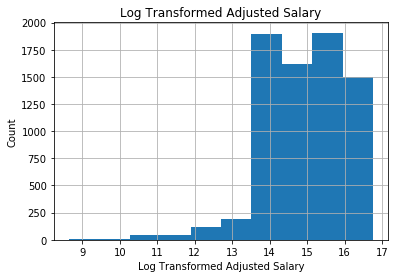

In [12]:
# take log transformation for salary
df['SALARY_LOG'] = np.log(df['SALARY_ADJ'])

# plot the log salary distribution
axarr = df.hist('SALARY_LOG')
for ax in axarr.flatten():
    ax.set_xlabel('Log Transformed Adjusted Salary')
    ax.set_ylabel('Count')
    ax.set_title('Log Transformed Adjusted Salary')

In [13]:
# label encode TEAM_ABBREVIATION to numbers
le = LabelEncoder()
le.fit(df['TEAM_ABBREVIATION'])
df['TEAM_ABBREVIATION'] = le.transform(df['TEAM_ABBREVIATION'])

In [14]:
# split features and raw target
X = df[[
    'GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS', 'YEAR', 'TEAM_ABBREVIATION']]
y = df['SALARY_ADJ']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 57)

# transform features by scaling each feature to (0, 1)
mms = MinMaxScaler()
mms.fit(X)
X_train_scaled = mms.transform(X_train)
X_test_scaled = mms.transform(X_test)

In [15]:
# split features and log salary
X = df[[
    'GP', 'MIN', 'FG_PCT', 'FGM', 'FGA', 'FG3M', 'FG3A',
    'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 
    'REB', 'AST', 'BLK', 'STL', 'PF', 'TOV', 'PTS', 'YEAR', 'TEAM_ABBREVIATION']]
y = df['SALARY_LOG']

# train test split for log salary
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X, y, 
    test_size = 0.25, random_state = 57)

# transform features by scaling each feature to (0, 1)
mms = MinMaxScaler()
mms.fit(X)
X_log_train_scaled = mms.transform(X_log_train)
X_log_test_scaled = mms.transform(X_log_test)

## Model

---

###### Linear Regression

In [16]:
# cross validation for Linear Regression
def lr_cv(X_tr, y_tr, X_te, y_te, n_splits = 5):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr[ti], y_tr[ti]
        valid_features, valid_labels = X_tr[vi], y_tr[vi]

        X_const = sm.add_constant(train_features)
        model = sm.OLS(train_labels, X_const)
        res = model.fit()
        
        oof[vi] = res.predict(sm.add_constant(valid_features))
        folds[ti] = res.predict(X_const)
        t_fold += res.predict(sm.add_constant(X_te))
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(train_labels, folds[ti]))
        mae_valid.append(mean_absolute_error(valid_labels, oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(y_te, np.round(t_fold / n_splits)))
    
    return mae_train, mae_valid, mae_test, res

In [17]:
mae_train, mae_valid, mae_test, res = lr_cv(X_train_scaled,  y_train.values, 
                                       X_test_scaled, y_test.values, n_splits = 5)
print('Mean Absolute Error for training set is ', np.mean(mae_train))
print('Mean Absolute Error for validation set is ', np.mean(mae_valid))
print('Mean Absolute Error for testing set is ', np.mean(mae_test))
print('\nResult Summary:\n')
_ = print(res.summary2())

Mean Absolute Error for training set is  2630391.631107287
Mean Absolute Error for validation set is  2643527.538128403
Mean Absolute Error for testing set is  2657534.652467322

Result Summary:

                       Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.412      
Dependent Variable:    y                   AIC:                   145222.6687
Date:                  2020-11-26 23:03    BIC:                   145369.6188
No. Observations:      4399                Log-Likelihood:        -72588.    
Df Model:              22                  F-statistic:           141.1      
Df Residuals:          4376                Prob (F-statistic):    0.00       
R-squared:             0.415               Scale:                 1.2661e+13 
-----------------------------------------------------------------------------
          Coef.        Std.Err.      t    P>|t|      [0.025         0.975]   
-----------------------------------------------

###### Linear Regression - Log Transformation

In [18]:
# cross validation for Linear Regression
def lr_log_cv(X_tr, y_tr, X_te, y_te, n_splits = 5):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr[ti], y_tr[ti]
        valid_features, valid_labels = X_tr[vi], y_tr[vi]

        X_const = sm.add_constant(train_features)
        model = sm.OLS(train_labels, X_const)
        res = model.fit()
        
        oof[vi] = res.predict(sm.add_constant(valid_features))
        folds[ti] = res.predict(X_const)
        t_fold += res.predict(sm.add_constant(X_te))
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(np.e**train_labels, np.e**folds[ti]))
        mae_valid.append(mean_absolute_error(np.e**valid_labels, np.e**oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(np.e**y_te, np.e**(np.round(t_fold / n_splits))))
    
    return mae_train, mae_valid, mae_test, res

In [19]:
mae_train, mae_valid, mae_test, res = lr_log_cv(X_log_train_scaled,  y_log_train.values, 
                                       X_log_test_scaled, y_log_test.values, n_splits = 5)
print('Mean Absolute Error for training set is ', np.mean(mae_train))
print('Mean Absolute Error for validation set is ', np.mean(mae_valid))
print('Mean Absolute Error for testing set is ', np.mean(mae_test))
print('\nResult Summary:\n')
_ = print(res.summary2())

Mean Absolute Error for training set is  2608951.783782035
Mean Absolute Error for validation set is  2624046.5130878882
Mean Absolute Error for testing set is  2697610.44458294

Result Summary:

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.379     
Dependent Variable: y                AIC:                11236.5446
Date:               2020-11-26 23:03 BIC:                11383.4947
No. Observations:   4399             Log-Likelihood:     -5595.3   
Df Model:           22               F-statistic:        123.2     
Df Residuals:       4376             Prob (F-statistic): 0.00      
R-squared:          0.382            Scale:              0.74920   
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      13.5969     0.1260   107.8967   0.0000   13.3498   13.843

###### Random Forest

In [20]:
# cross validation for Random Forest
def rf_cv(X_tr, y_tr, X_te, y_te, n_splits = 5, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        rf = RandomForestRegressor(n_estimators = n, max_depth = 7, random_state = 57)
        rf.fit(train_features, train_labels)
        
        oof[vi] = rf.predict(valid_features)
        folds[ti] = rf.predict(train_features)
        t_fold += rf.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(train_labels, folds[ti]))
        mae_valid.append(mean_absolute_error(valid_labels, oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(y_te, np.round(t_fold / n_splits)))
    
    return mae_train, mae_valid, mae_test

In [21]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_train.reset_index(drop = True, inplace = True)
for n in [50, 100, 150, 200]:
    mae_train, mae_valid, mae_test = rf_cv(X_train,  y_train.values, X_test, y_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)
    
print('Best Model:')
print('N = ', N[mae_valid_list.index(np.min(mae_valid_list))])
print('Training MAE: ', mae_train_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.min(mae_valid_list))][0])

Best Model:
N =  150
Training MAE:  2217324.2576361643
Validation MAE:  2599302.363417224
Testing MAE:  2576967.6414939314


###### Random Forest - Log Transformation

In [22]:
# cross validation for Random Forest
def rf_log_cv(X_tr, y_tr, X_te, y_te, n_splits = 10, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        rf = RandomForestRegressor(n_estimators = n, max_depth = 6, random_state = 57)
        rf.fit(train_features, train_labels)
        
        oof[vi] = rf.predict(valid_features)
        folds[ti] = rf.predict(train_features)
        t_fold += rf.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(np.e**train_labels, np.e**folds[ti]))
        mae_valid.append(mean_absolute_error(np.e**valid_labels, np.e**oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(np.e**y_te, np.e**(np.round(t_fold / n_splits))))
    
    return mae_train, mae_valid, mae_test

In [23]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_log_train.reset_index(drop = True, inplace = True)
for n in [150, 200, 250, 300]:
    mae_train, mae_valid, mae_test = rf_log_cv(X_log_train,  y_log_train.values, X_log_test, y_log_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)

print('Best Model:')
print('N = ', N[mae_valid_list.index(np.min(mae_valid_list))])
print('Training MAE: ', mae_train_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.min(mae_valid_list))][0])

Best Model:
N =  200
Training MAE:  2420796.699509752
Validation MAE:  2614012.60731351
Testing MAE:  2683214.3503682013


###### XGBoost

In [24]:
# cross validation for XGBoost
def xgb_cv(X_tr, y_tr, X_te, y_te, n_splits = 5, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        xgb_model = xgb.XGBRegressor(n_estimators = n, 
                                     objective ='reg:squarederror',
                                     max_depth = 5,
                                     random_state = 57)
        xgb_model.fit(train_features, train_labels)
        
        oof[vi] = xgb_model.predict(valid_features)
        folds[ti] = xgb_model.predict(train_features)
        t_fold += xgb_model.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(train_labels, folds[ti]))
        mae_valid.append(mean_absolute_error(valid_labels, oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(y_te, np.round(t_fold / n_splits)))
    
    return mae_train, mae_valid, mae_test

In [25]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_train.reset_index(drop = True, inplace = True)
for n in [50, 100, 150]:
    mae_train, mae_valid, mae_test = xgb_cv(X_train,  y_train.values, X_test, y_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)

print('Best Model:')
print('N = ', N[mae_valid_list.index(np.min(mae_valid_list))])
print('Training MAE: ', mae_train_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.min(mae_valid_list))][0])

Best Model:
N =  100
Training MAE:  1805619.0055404957
Validation MAE:  2543037.3842429225
Testing MAE:  2506490.7989406576


###### XGBoost - Log Transformation

In [26]:
# cross validation for XGBoost
def xgb_log_cv(X_tr, y_tr, X_te, y_te, n_splits = 5, n = 100):

    # define kfold and loop through each iteration
    kf = KFold(n_splits = n_splits, shuffle = True, random_state = 57)

    # out of fold empty array
    oof = np.zeros(shape = (X_tr.shape[0]))
    # folds empty array
    folds = np.zeros(shape = (X_tr.shape[0]))
    # test empty array
    t_fold = np.zeros(shape = (X_te.shape[0]))

    # initial train, test and validation MAE
    mae_train = []
    mae_valid = []
    mae_test = []
    
    for ti, vi in kf.split(X_tr):
        
        # split train and valid dataframe
        train_features, train_labels = X_tr.loc[ti], y_tr[ti]
        valid_features, valid_labels = X_tr.loc[vi], y_tr[vi]

        xgb_model = xgb.XGBRegressor(n_estimators = n, 
                                     objective ='reg:squarederror',
                                     max_depth = 5,
                                     random_state = 57)
        xgb_model.fit(train_features, train_labels)
        
        oof[vi] = xgb_model.predict(valid_features)
        folds[ti] = xgb_model.predict(train_features)
        t_fold += xgb_model.predict(X_te)
        
        # update MAE score for train and validation
        mae_train.append(mean_absolute_error(np.e**train_labels, np.e**folds[ti]))
        mae_valid.append(mean_absolute_error(np.e**valid_labels, np.e**oof[vi]))
    
    # update MAE score for test
    mae_test.append(mean_absolute_error(np.e**y_te, np.e**(np.round(t_fold / n_splits))))
    
    return mae_train, mae_valid, mae_test

In [27]:
# grid search for best model based on MAE score
mae_train_list = []
mae_valid_list = []
mae_test_list = []
N = []
X_log_train.reset_index(drop = True, inplace = True)
for n in [50, 100, 150, 200]:
    mae_train, mae_valid, mae_test = xgb_log_cv(X_log_train,  y_log_train.values, X_log_test, y_log_test.values, n_splits = 5, n = n)
    N.append(n)
    mae_train_list.append(np.mean(mae_train))
    mae_valid_list.append(np.mean(mae_valid))
    mae_test_list.append(mae_test)

print('Best Model:')
print('N = ', N[mae_valid_list.index(np.min(mae_valid_list))])
print('Training MAE: ', mae_train_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Validation MAE: ', mae_valid_list[mae_valid_list.index(np.min(mae_valid_list))])
print('Testing MAE: ', mae_test_list[mae_valid_list.index(np.min(mae_valid_list))][0])

Best Model:
N =  100
Training MAE:  2028077.6647273072
Validation MAE:  2567475.667569154
Testing MAE:  2658717.4650750044


After comparint the models' performance, we select XGBRegressor predicting Adjusted salary as our final model. The model has testing mean absolute error of 2,506,490.

## Feature Importance

---

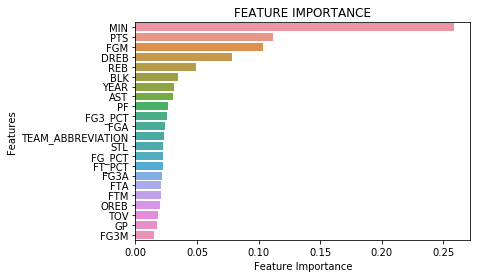

In [36]:
# select the best performance model
xgb_model = xgb.XGBRegressor(n_estimators = 100, max_depth = 5, 
                             objective ='reg:squarederror', random_state = 57)
xgb_model.fit(X_train,  y_train.values)

# dataframe for feature importance and feature names
feature_importance = np.array(xgb_model.feature_importances_)
features = np.array(X_train.columns)
fi_df = pd.DataFrame({'features':features,'feature_importance':feature_importance})

# sort the dataframe by feature importance
fi_df.sort_values(by=['feature_importance'], ascending = False , inplace = True)


# plot bar chart
sns.barplot(fi_df['feature_importance'], fi_df['features'])
plt.title('FEATURE IMPORTANCE')
plt.xlabel('Feature Importance')
_ = plt.ylabel('Features')

The top three important features are minutes played per game, points per game and field goal made per game.

## Reasons of Large MAE

---

In [37]:
# make predictions for X_test
pred = pd.DataFrame({'prediction': xgb_model.predict(X_test)})
X_test_temp = X_test.reset_index(drop = True)
y_test_temp = y_test.reset_index(drop = True)

In [38]:
# compute the difference of actual salary and prediction
result = pd.concat([X_test_temp, pred, y_test_temp], axis = 1)
result['diff'] = result['SALARY_ADJ'] - result['prediction']
result['diff'].describe()

count    1.833000e+03
mean    -1.139099e+05
std      3.449223e+06
min     -1.099371e+07
25%     -1.956912e+06
50%     -5.993710e+05
75%      1.340231e+06
max      1.476059e+07
Name: diff, dtype: float64

In [60]:
# stats of Top three important features
result.describe()[['MIN', 'PTS', 'FGM']].round()

,MIN,PTS,FGM
count,1833.0,1833.0,1833.0
mean,21.0,8.0,3.0
std,9.0,5.0,2.0
min,1.0,0.0,0.0
25%,14.0,4.0,2.0
50%,21.0,7.0,3.0
75%,28.0,11.0,4.0
max,42.0,32.0,11.0


In [39]:
# get top 10 observations with the most salary and prediction difference

# create name list
names = []
# get player names
for i in result.sort_values('diff').index[-10:].values:
    j = int(X_test[i:i+1].index.values)
    names.append(df[j:j + 1]['PLAYER_NAME'].values[0])

# create top 10 overvalued paler dataframe
top_10_overvalued = result.sort_values('diff')[-10:].reset_index(drop = True)
names = pd.DataFrame({'PLAYER_NAME': names})
top_10_overvalued = pd.concat([names, top_10_overvalued], axis = 1)

In [61]:
top_10_overvalued[['PLAYER_NAME', 'MIN', 'PTS', 'FGM', 
                   'YEAR', 'SALARY_ADJ', 'prediction', 'diff']].sort_values(
    by = 'diff', ascending = False).reset_index(drop = True).round()

,PLAYER_NAME,MIN,PTS,FGM,YEAR,SALARY_ADJ,prediction,diff
0,Paul George,15.0,9.0,3.0,2014,18642783.0,3882196.0,14760588.0
1,Jeff Teague,25.0,11.0,4.0,2019,19000000.0,4691902.0,14308098.0
2,Shawn Kemp,16.0,6.0,2.0,2000,18602786.0,4671933.0,13930853.0
3,Raef LaFrentz,13.0,4.0,1.0,2006,15477536.0,2149181.0,13328355.0
4,Ian Mahinmi,18.0,6.0,2.0,2016,16786903.0,4153729.0,12633174.0
5,Brandon Knight,19.0,7.0,2.0,2018,15800188.0,3394975.0,12405212.0
6,Gary Harris,29.0,13.0,5.0,2018,18017679.0,5641946.0,12375733.0
7,Gary Harris,32.0,10.0,4.0,2019,17839286.0,5830866.0,12008420.0
8,Elton Brand,30.0,13.0,5.0,2009,18902182.0,7039169.0,11863013.0
9,Nick Collison,21.0,6.0,2.0,2009,15717175.0,4020148.0,11697027.0


Potential reasons why some palyers are overvalued:

1. Some of the palyers may have contracts with the teams for several consecutive years, where the salaries do not change a lot by their performance.
2. Although some players do not have fancy stats in some seasons, the team coach sees their potential or thinks they may be a good fit for the whole team. For example, Jeff Teague suffers from ankle and knee injury but still has a decent salary.
3. Players who are super famous tend to have higher salaries.

In [41]:
# get top 10 observations with the most prediction and salary difference

# create name list
names = []
for i in result.sort_values('diff').index[:10].values:
    j = int(X_test[i:i+1].index.values)
    names.append(df[j:j + 1]['PLAYER_NAME'].values[0])
    
# create top 10 undervalued paler dataframe
top_10_undervalued = result.sort_values('diff')[:10].reset_index(drop = True)
names = pd.DataFrame({'PLAYER_NAME': names})
top_10_undervalued = pd.concat([names, top_10_undervalued], axis = 1)

In [62]:
top_10_undervalued[['PLAYER_NAME', 'MIN', 'PTS', 'FGM', 'YEAR', 'SALARY_ADJ', 'prediction', 'diff']].round()

,PLAYER_NAME,MIN,PTS,FGM,YEAR,SALARY_ADJ,prediction,diff
0,Joe Johnson,35.0,14.0,6.0,2014,285187.0,11278896.0,-10993709.0
1,Chris Bosh,39.0,22.0,8.0,2005,5416554.0,15823448.0,-10406894.0
2,Derrick Rose,32.0,18.0,7.0,2016,306330.0,10359596.0,-10053266.0
3,John Collins,33.0,22.0,9.0,2019,2686560.0,12435296.0,-9748736.0
4,Giannis Antetokounmpo,35.0,17.0,6.0,2015,3219977.0,12560490.0,-9340513.0
5,Lamar Odom,37.0,17.0,6.0,2000,4096401.0,13377620.0,-9281219.0
6,Greivis Vasquez,34.0,14.0,6.0,2012,2381269.0,11637802.0,-9256533.0
7,Brandon Roy,38.0,19.0,7.0,2007,3696620.0,12897720.0,-9201100.0
8,Josh Smith,37.0,16.0,6.0,2006,2791183.0,11805666.0,-9014483.0
9,Russell Westbrook,35.0,22.0,8.0,2010,5833028.0,14833960.0,-9000932.0


Potential reasons why some palyers are undervalued:

1. Some of the players have good performance, but they are new to NBA. For example, Chris Bosh was a new player in 2005. That's why he had a low salary but great performance. His salary goes up to 13 million in 2007.

2. Official NBA website doesn't contain salary data so that we can only get the data from third party websites. There are some discrepancies between those websites. For example, Joe Johnson has raw salary 261,894 reported by ESPN, while hoopshype reports 21,894,863.

Quantifying or collecting the potential features stated above is not feasible. We conclude that player performance data plays a very import role in predicting salary but the model could be improved by introduing new features and compare data between several third party websites.

Besides, our model can be used to determine whether a player is overvalued or undervalued based on his previous year's performance and current year's salary.